In [17]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "cs231n_Feifei/assignments/2021/assignment3"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/MyDrive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/MyDrive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs231n_Feifei/assignments/2021/assignment3/cs231n/datasets
/content/drive/MyDrive/cs231n_Feifei/assignments/2021/assignment3


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Using GPU

Go to `Runtime > Change runtime type` and set `Hardware accelerator` to `GPU`. This will reset Colab. **Rerun the top cell to mount your Drive again.**

# Self-Supervised Learning 

## What is self-supervised learning?
Modern day machine learning requires lots of labeled data. But often times it's challenging and/or expensive to obtain large amounts of human-labeled data. Is there a way we could ask machines to automatically learn a model which can generate good visual representations without a labeled dataset? Yes, enter self-supervised learning! 

Self-supervised learning (SSL) allows models to automatically learn a "good" representation space using the data in a given dataset without the need for their labels. Specifically, if our dataset were a bunch of images, then self-supervised learning allows a model to learn and generate a "good" representation vector for images. 

The reason SSL methods have seen a surge in popularity is because the learnt model continues to perform well on other datasets as well i.e. new datasets on which the model was not trained on!

## What makes a "good" representation?
A "good" representation vector needs to capture the important features of the image as it relates to the rest of the dataset. This means that images in the dataset representing semantically similar entities should have similar representation vectors, and different  images in the dataset should have different representation vectors. For example, two images of an apple should have similar representation vectors, while an image of an apple and an image of a banana should have different representation vectors.

## Contrastive Learning: SimCLR
Recently, [SimCLR](https://arxiv.org/pdf/2002.05709.pdf) introduces a new architecture which uses **contrastive learning** to learn good visual representations. Contrastive learning aims to learn similar representations for similar images and different representations for different images. As we will see in this notebook, this simple idea allows us to train a surprisingly good model without using any labels.

Specifically, for each image in the dataset, SimCLR generates two differently augmented views of that image, called a **positive pair**. Then, the model is encouraged to generate similar representation vectors for this pair of images. See below for an illustration of the architecture (Figure 2 from the paper).

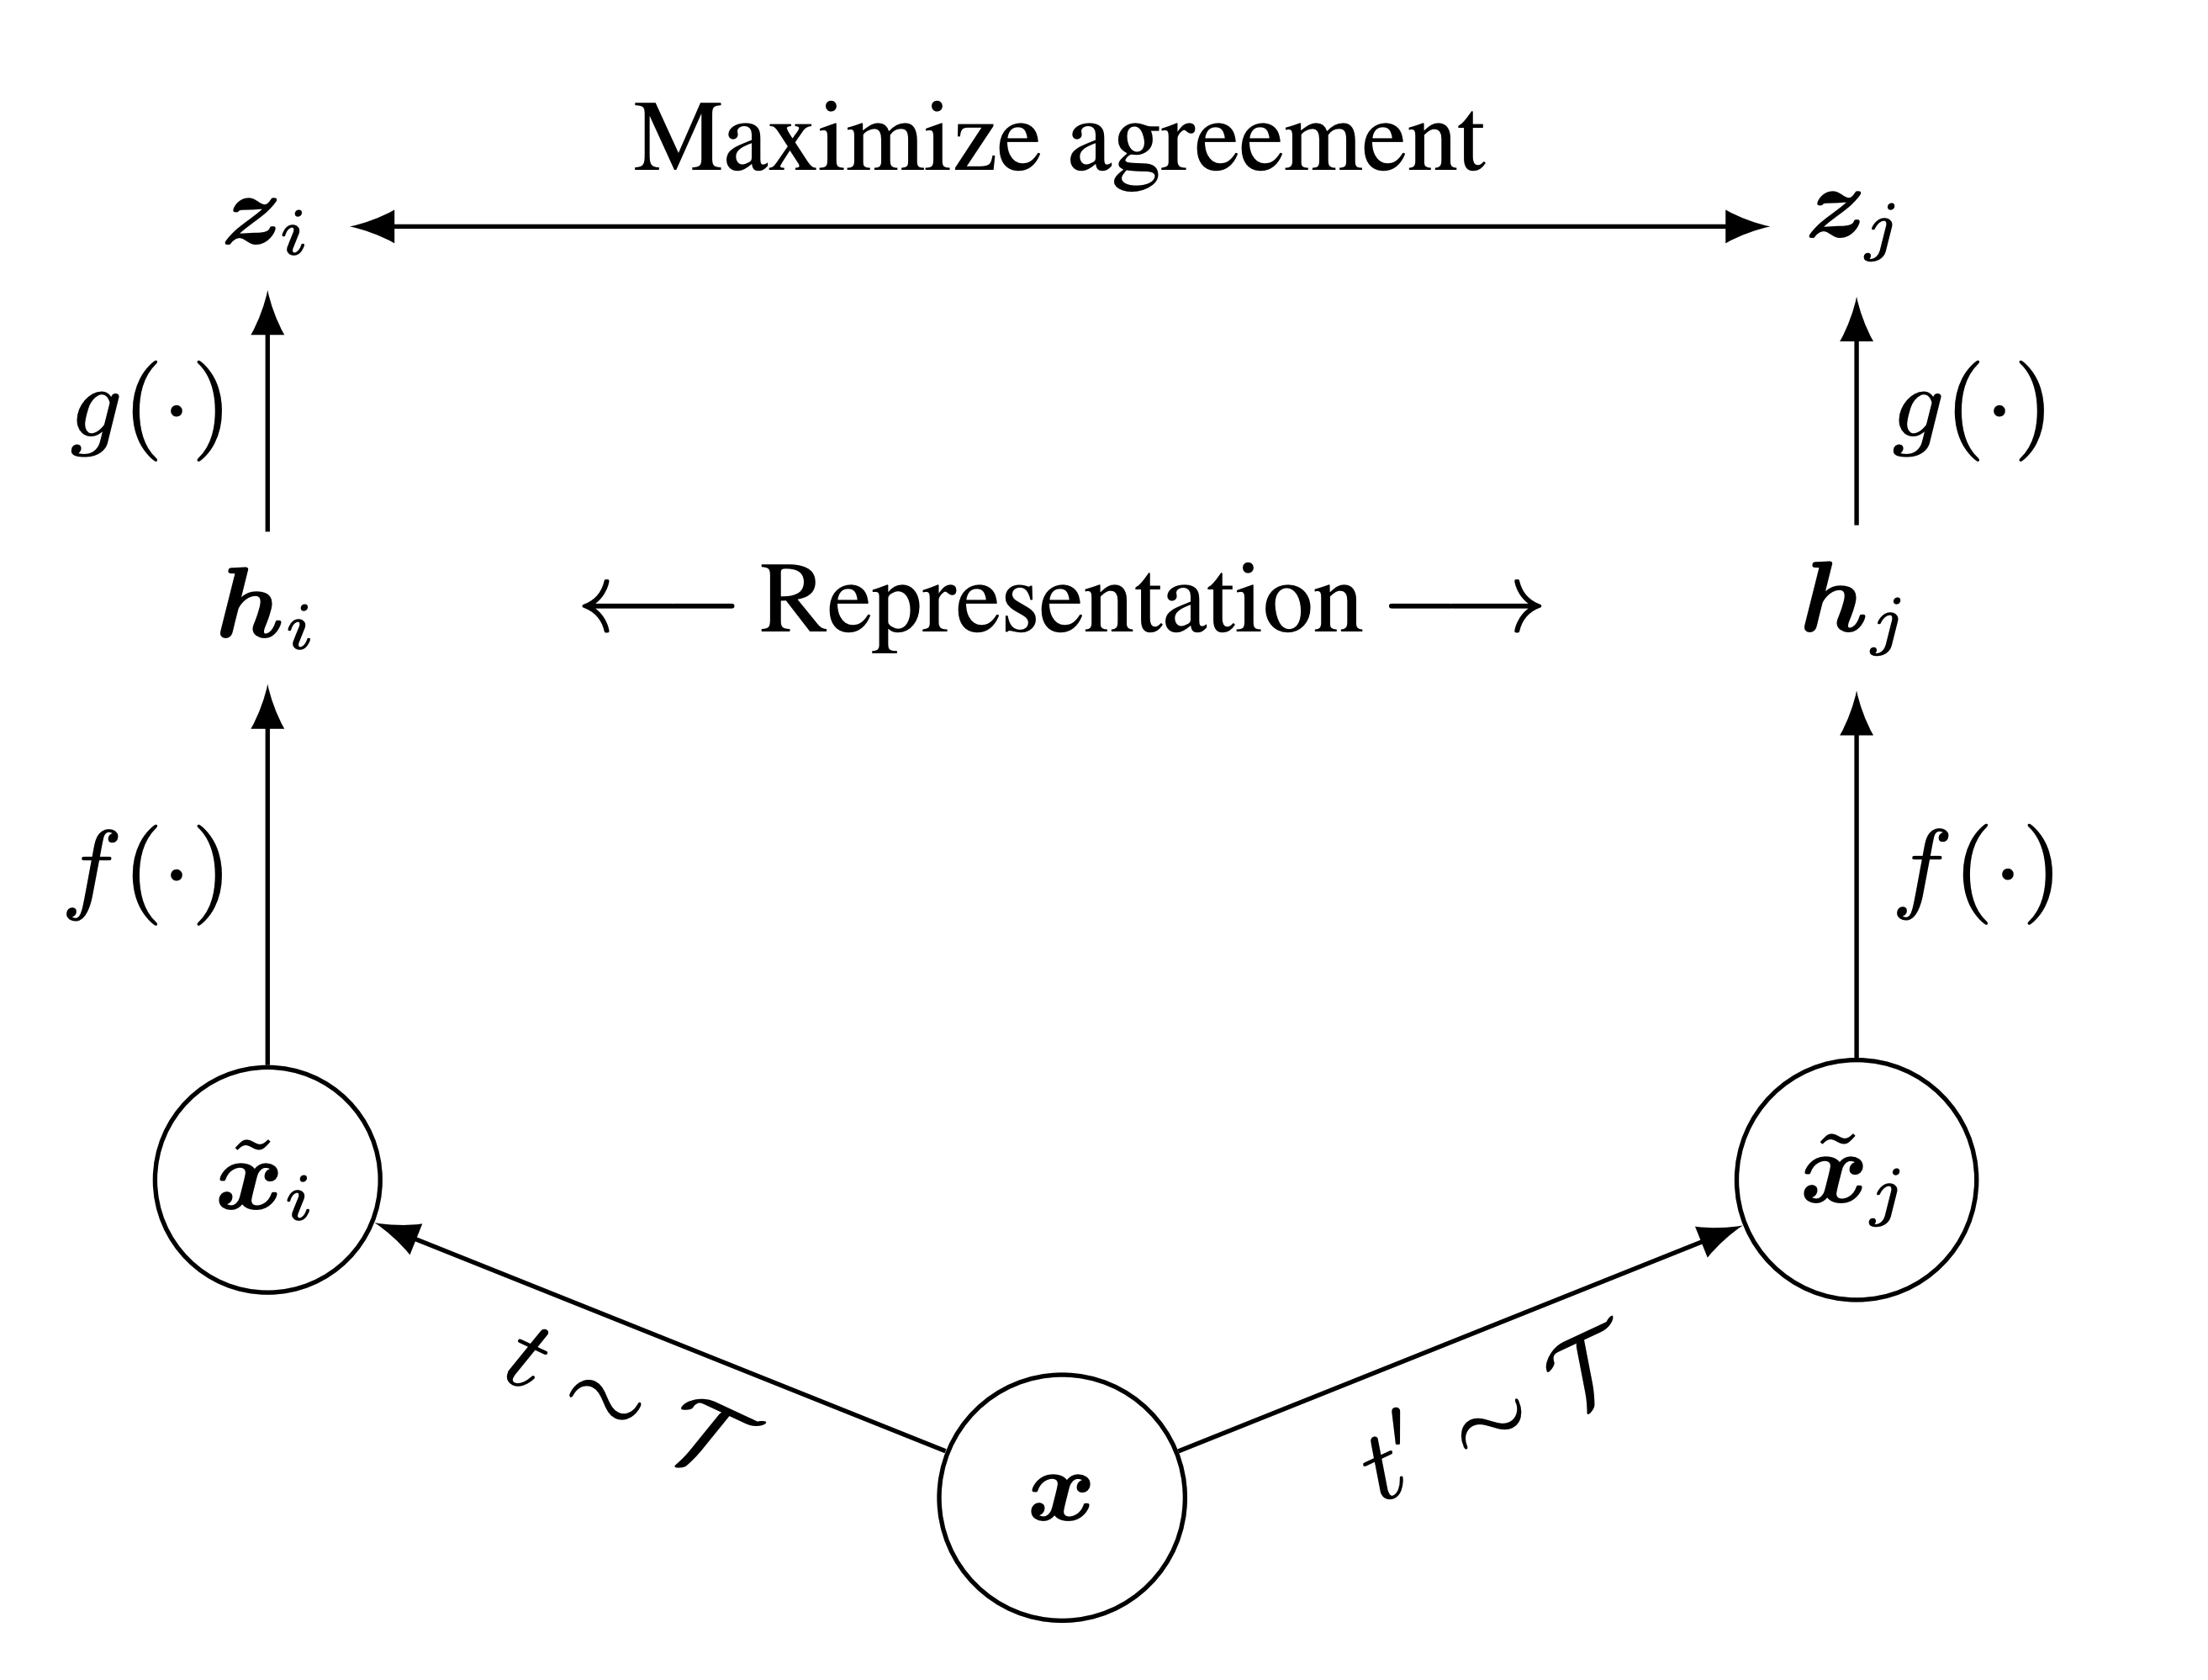

In [19]:
# Run this cell to view the SimCLR architecture.
from IPython.display import Image
Image('images/simclr_fig2.png', width=500)

Given an image **x**, SimCLR uses two different data augmentation schemes **t** and **t'** to generate the positive pair of images **$\hat{x}_i$** and **$\hat{x}_j$**. $f$ is a basic encoder net that  extracts representation vectors from the augmented data samples, which yields **$h_i$** and **$h_j$**, respectively. Finally, a small neural network projection head $g$ maps the representation vectors to the space where the contrastive loss is applied. The goal of the contrastive loss is to maximize agreement between the final vectors **$z_i = g(h_i)$** and **$z_j = g(h_j)$**. We will discuss the contrastive loss in more detail later, and you will get to implement it.

After training is completed, we throw away the projection head $g$ and only use $f$ and the representation $h$ to perform downstream tasks, such as classification. You will get a chance to finetune a layer on top of a trained SimCLR model for a classification task and compare its performance with a baseline model (without self-supervised learning).

## Pretrained Weights
For your convenience, we have given you pretrained weights (trained for ~18 hours on CIFAR-10) for the SimCLR model. Run the following cell to download pretrained model weights to be used later. (This will take ~1 minute)

In [20]:
%%bash
DIR=pretrained_model/
if [ ! -d "$DIR" ]; then
    mkdir "$DIR" 
fi

URL=http://downloads.cs.stanford.edu/downloads/cs231n/pretrained_simclr_model.pth
FILE=pretrained_model/pretrained_simclr_model.pth
if [ ! -f "$FILE" ]; then
    echo "Downloading weights..."
    wget "$URL" -O "$FILE"
fi

In [21]:
# Setup cell.
%pip install thop
import torch
import os
import importlib
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn as nn
import random
from thop import profile, clever_format
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Augmentation

Our first step is to perform data augmentation. Implement the `compute_train_transform()` function in `cs231n/simclr/data_utils.py` to apply the following random transformations:

1. Randomly resize and crop to 32x32.
2. Horizontally flip the image with probability 0.5
3. With a probability of 0.8, apply color jitter (see `compute_train_transform()` for definition)
4. With a probability of 0.2, convert the image to grayscale

Now complete `compute_train_transform()` and `CIFAR10Pair.__getitem__()` in `cs231n/simclr/data_utils.py` to apply the data augmentation transform and generate **$\hat{x}_i$** and **$\hat{x}_j$**.



Test to make sure that your data augmentation code is correct:

In [22]:
from cs231n.simclr.data_utils import *
from cs231n.simclr.contrastive_loss import *

answers = torch.load('simclr_sanity_check.key')

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


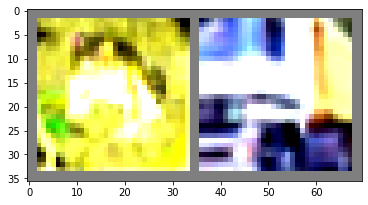

Maximum error in data augmentation: 0


In [23]:
from PIL import Image
import torchvision
from torchvision.datasets import CIFAR10

def test_data_augmentation(correct_output=None):
    train_transform = compute_train_transform(seed=2147483647)
    # print(train_transform)
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=False, num_workers=2)
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    output = images
    
    print("Maximum error in data augmentation: %g"%rel_error( output.numpy(), correct_output.numpy()))
    # print(correct_output.numpy())
    # print(f"output:{output.numpy()}")

# Should be less than 1e-07.
test_data_augmentation(answers['data_augmentation'])

# Base Encoder and Projection Head
The next steps are to apply the base encoder and projection head to the augmented samples **$\hat{x}_i$** and **$\hat{x}_j$**.

The base encoder $f$ extracts representation vectors for the augmented samples. The SimCLR paper found that using deeper and wider models improved performance and thus chose [ResNet](https://arxiv.org/pdf/1512.03385.pdf) to use as the base encoder. The output of the base encoder are the representation vectors **$h_i = f(\hat{x}_i$)** and **$h_j = f(\hat{x}_j$)**.

The projection head $g$ is a small neural network that maps the representation vectors **$h_i$** and **$h_j$** to the space where the contrastive loss is applied. The paper found that using a nonlinear projection head improved the representation quality of the layer before it. Specifically, they used a MLP with one hidden layer as the projection head $g$. The contrastive loss is then computed based on the outputs **$z_i = g(h_i$)** and **$z_j = g(h_j$)**.

We provide implementations of these two parts in `cs231n/simclr/model.py`. Please skim through the file and make sure you understand the implementation.

# SimCLR: Contrastive Loss

A mini-batch of $N$ training images yields a total of $2N$ data-augmented examples. For each positive pair $(i, j)$ of augmented examples, the contrastive loss function aims to maximize the agreement of vectors $z_i$ and $z_j$. Specifically, the loss is the normalized temperature-scaled cross entropy loss and aims to maximize the agreement of $z_i$ and $z_j$ relative to all other augmented examples in the batch:

$$
l \; (i, j) = -\log \frac{\exp (\;\text{sim}(z_i, z_j)\; / \;\tau) }{\sum_{k=1}^{2N} \mathbb{1}_{k \neq i} \exp (\;\text{sim} (z_i, z_k) \;/ \;\tau) }
$$

where $\mathbb{1} \in \{0, 1\}$ is an indicator function that outputs $1$ if $k\neq i$ and $0$ otherwise. $\tau$ is a temperature parameter that determines how fast the exponentials increase.

sim$(z_i, z_j) = \frac{z_i \cdot z_j}{|| z_i || || z_j ||}$ is the (normalized) dot product between vectors $z_i$ and $z_j$. The higher the similarity between $z_i$ and $z_j$, the larger the dot product is, and the larger the numerator becomes. The denominator normalizes the value by summing across $z_i$ and all other augmented examples $k$ in the batch. The range of the normalized value is $(0, 1)$, where a high score close to $1$ corresponds to a high similarity between the positive pair $(i, j)$ and low similarity between $i$ and other augmented examples $k$ in the batch. The negative log then maps the range $(0, 1)$ to the loss values $(\inf, 0)$. 

The total loss is computed across all positive pairs $(i, j)$ in the batch. Let $z = [z_1, z_2, ..., z_{2N}]$ include all the augmented examples in the batch, where $z_{1}...z_{N}$ are outputs of the left branch, and $z_{N+1}...z_{2N}$ are outputs of the right branch. Thus, the positive pairs are $(z_{k}, z_{k + N})$ for $\forall k \in [1, N]$. 

Then, the total loss $L$ is:

$$
L = \frac{1}{2N} \sum_{k=1}^N [ \; l(k, \;k+N) + l(k+N, \;k)\;]
$$

**NOTE:** this equation is slightly different from the one in the paper. We've rearranged the ordering of the positive pairs in the batch, so the indices are different. The rearrangement makes it easier to implement the code in vectorized form.

We'll walk through the steps of implementing the loss function in vectorized form. Implement the functions `sim`, `simclr_loss_naive` in `cs231n/simclr/contrastive_loss.py`. Test your code by running the sanity checks below.

In [24]:
from cs231n.simclr.contrastive_loss import *
answers = torch.load('simclr_sanity_check.key')

In [25]:
def test_sim(left_vec, right_vec, correct_output):
    output = sim(left_vec, right_vec).cpu().numpy()
    print("Maximum error in sim: %g"%rel_error(correct_output.numpy(), output))

# Should be less than 1e-07.
test_sim(answers['left'][0], answers['right'][0], answers['sim'][0])
test_sim(answers['left'][1], answers['right'][1], answers['sim'][1])

Maximum error in sim: 3.81097e-08
Maximum error in sim: 0


In [26]:
def test_loss_naive(left, right, tau, correct_output):
    naive_loss = simclr_loss_naive(left, right, tau).item()
    print("Maximum error in simclr_loss_naive: %g"%rel_error(correct_output, naive_loss))

# Should be less than 1e-07.
test_loss_naive(answers['left'], answers['right'], 5.0, answers['loss']['5.0'])
test_loss_naive(answers['left'], answers['right'], 1.0, answers['loss']['1.0'])

Maximum error in simclr_loss_naive: 5.47663e-08
Maximum error in simclr_loss_naive: 5.65617e-08


Now implement the vectorized version by implementing `sim_positive_pairs`, `compute_sim_matrix`, `simclr_loss_vectorized` in `cs231n/simclr/contrastive_loss.py`.  Test your code by running the sanity checks below.

In [27]:
def test_sim_positive_pairs(left, right, correct_output):
    sim_pair = sim_positive_pairs(left, right).cpu().numpy()
    print("Maximum error in sim_positive_pairs: %g"%rel_error(correct_output.numpy(), sim_pair))
    # print(f"correct:{correct_output.numpy().shape}")
    # print(f"our:{sim_pair}")

# Should be less than 1e-07.
test_sim_positive_pairs(answers['left'], answers['right'], answers['sim'])

Maximum error in sim_positive_pairs: 3.81097e-08


In [28]:
def test_sim_matrix(left, right, correct_output):
    out = torch.cat([left, right], dim=0)
    sim_matrix = compute_sim_matrix(out).cpu()
    assert torch.isclose(sim_matrix, correct_output).all(), "correct: {}. got: {}".format(correct_output, sim_matrix)
    print("Test passed!")

test_sim_matrix(answers['left'], answers['right'], answers['sim_matrix'])

Test passed!


In [29]:
def test_loss_vectorized(left, right, tau, correct_output):
    vec_loss = simclr_loss_vectorized(left, right, tau, device).item()
    print("Maximum error in loss_vectorized: %g"%rel_error(correct_output, vec_loss))
    print(f"correct:{correct_output}")
    print(f"our:{vec_loss}")

# Should be less than 1e-07.
test_loss_vectorized(answers['left'], answers['right'], 5.0, answers['loss']['5.0'])
test_loss_vectorized(answers['left'], answers['right'], 1.0, answers['loss']['1.0'])

Maximum error in loss_vectorized: 0
correct:1.0883455276489258
our:1.0883455276489258
Maximum error in loss_vectorized: 1.13123e-07
correct:1.0537996292114258
our:1.0537993907928467


# Implement the train function
Complete the `train()` function in `cs231n/simclr/utils.py` to obtain the model's output and use `simclr_loss_vectorized` to compute the loss. (Please take a look at the `Model` class in `cs231n/simclr/model.py` to understand the model pipeline and the returned values)

In [30]:
from cs231n.simclr.data_utils import *
from cs231n.simclr.model import *
from cs231n.simclr.utils import *

### Train the SimCLR model

Run the following cells to load in the pretrained weights and continue to train a little bit more. This part will take ~10 minutes and will output to `pretrained_model/trained_simclr_model.pth`.

**NOTE:** Don't worry about logs such as '_[WARN] Cannot find rule for ..._'. These are related to another module used in the notebook. You can verify the integrity of your code changes through our provided prompts and comments.

In [31]:
# Do not modify this cell.
feature_dim = 128
temperature = 0.5
k = 200
batch_size = 64
epochs = 1
temperature = 0.5
percentage = 0.5
pretrained_path = './pretrained_model/pretrained_simclr_model.pth'

# Prepare the data.
train_transform = compute_train_transform()
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_data = torch.utils.data.Subset(train_data, list(np.arange(int(len(train_data)*percentage))))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)
test_transform = compute_test_transform()
memory_data = CIFAR10Pair(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_data = CIFAR10Pair(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

# Set up the model and optimizer config.
model = Model(feature_dim)
model.load_state_dict(torch.load(pretrained_path, map_location='cpu'), strict=False)
model = model.to(device)
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).to(device),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
c = len(memory_data.classes)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Files already downloaded and verified
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[WARN] Cannot find rule for <class 'cs231n.simclr.model.Model'>. Treat it as zero Macs and zero Params.
# Model Params: 24.62M FLOPs: 1.31G


In [34]:
# Training loop.
results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': []} #<< -- output

if not os.path.exists('results'):
    os.mkdir('results')
best_acc = 0.0
for epoch in range(1, epochs + 1):
  train_loss = train(model, train_loader, optimizer, epoch, epochs, batch_size=batch_size, temperature=temperature, device=device)
  results['train_loss'].append(train_loss)
  test_acc_1, test_acc_5 = test(model, memory_loader, test_loader, epoch, epochs, c, k=k, temperature=temperature, device=device)
  results['test_acc@1'].append(test_acc_1)
  results['test_acc@5'].append(test_acc_5)
  
  # Save statistics.
  if test_acc_1 > best_acc:
      best_acc = test_acc_1
      torch.save(model.state_dict(), './pretrained_model/trained_simclr_model.pth')

流式输出内容被截断，只能显示最后 5000 行内容。


Train Epoch: [1/1] Loss: 2.9326:  16%|█▌        | 61/390 [00:31<02:27,  2.24it/s]


Train Epoch: [1/1] Loss: 2.9326:  16%|█▌        | 62/390 [00:31<02:26,  2.24it/s]


Train Epoch: [1/1] Loss: 2.9325:  16%|█▌        | 62/390 [00:32<02:26,  2.24it/s]


Train Epoch: [1/1] Loss: 2.9325:  16%|█▌        | 63/390 [00:32<02:25,  2.25it/s]


Train Epoch: [1/1] Loss: 2.9325:  16%|█▌        | 63/390 [00:32<02:25,  2.25it/s]


Train Epoch: [1/1] Loss: 2.9325:  16%|█▋        | 64/390 [00:32<02:26,  2.23it/s]


Train Epoch: [1/1] Loss: 2.9324:  16%|█▋        | 64/390 [00:32<02:26,  2.23it/s]


Train Epoch: [1/1] Loss: 2.9324:  17%|█▋        | 65/390 [00:32<02:25,  2.23it/s]


Train Epoch: [1/1] Loss: 2.9323:  17%|█▋        | 65/390 [00:33<02:25,  2.23it/s]


Train Epoch: [1/1] Loss: 2.9323:  17%|█▋        | 66/390 [00:33<02:25,  2.22it/s]


Train Epoch: [1/1] Loss: 2.9323:  17%|█▋        | 66/390 [00:33<02:25,  2.22it/s]


Train Epoch: [1/1] Loss: 2.9323:  17%|█▋       

# Finetune a Linear Layer for Classification!

Now it's time to put the representation vectors to the test!

We remove the projection head from the SimCLR model and slap on a linear layer to finetune for a simple classification task. All layers before the linear layer are frozen, and only the weights in the final linear layer are trained. We compare the performance of the SimCLR + finetuning model against a baseline model, where no self-supervised learning is done beforehand, and all weights in the model are trained. You will get to see for yourself the power of self-supervised learning and how the learned representation vectors improve downstream task performance.


## Baseline: Without Self-Supervised Learning
First, let's take a look at the baseline model. We'll remove the projection head from the SimCLR model and slap on a linear layer to finetune for a simple classification task. No self-supervised learning is done beforehand, and all weights in the model are trained. Run the following cells.
 
**NOTE:** Don't worry if you see low but reasonable performance.

In [35]:
class Classifier(nn.Module):
    def __init__(self, num_class):
        super(Classifier, self).__init__()

        # Encoder.
        self.f = Model().f
        
        # Classifier.
        self.fc = nn.Linear(2048, num_class, bias=True)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return out

In [ ]:
# Do not modify this cell.
feature_dim = 128
temperature = 0.5
k = 200
batch_size = 128
epochs = 10
percentage = 0.1

train_transform = compute_train_transform()
train_data = CIFAR10(root='data', train=True, transform=train_transform, download=True)
trainset = torch.utils.data.Subset(train_data, list(np.arange(int(len(train_data)*percentage))))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
test_transform = compute_test_transform()
test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

model = Classifier(num_class=len(train_data.classes)).to(device)
for param in model.f.parameters():
    param.requires_grad = False

flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).to(device),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-6)
no_pretrain_results = {'train_loss': [], 'train_acc@1': [], 'train_acc@5': [],
           'test_loss': [], 'test_acc@1': [], 'test_acc@5': []}

best_acc = 0.0
for epoch in range(1, epochs + 1):
    train_loss, train_acc_1, train_acc_5 = train_val(model, train_loader, optimizer, epoch, epochs, device='cuda')
    no_pretrain_results['train_loss'].append(train_loss)
    no_pretrain_results['train_acc@1'].append(train_acc_1)
    no_pretrain_results['train_acc@5'].append(train_acc_5)
    test_loss, test_acc_1, test_acc_5 = train_val(model, test_loader, None, epoch, epochs)
    no_pretrain_results['test_loss'].append(test_loss)
    no_pretrain_results['test_acc@1'].append(test_acc_1)
    no_pretrain_results['test_acc@5'].append(test_acc_5)
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        
# Print the best test accuracy.
print('Best top-1 accuracy without self-supervised learning: ', best_acc)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified





  0%|          | 0/40 [00:00<?, ?it/s]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.Classifier'>. Treat it as zero Macs and zero Params.
# Model Params: 23.52M FLOPs: 1.30G


流式输出内容被截断，只能显示最后 5000 行内容。


Train Epoch: [3/10] Loss: 2.5837 ACC@1: 10.16% ACC@5: 47.92%:   5%|▌         | 2/40 [00:02<00:55,  1.47s/it]


Train Epoch: [3/10] Loss: 2.5837 ACC@1: 10.16% ACC@5: 47.92%:   8%|▊         | 3/40 [00:02<00:40,  1.09s/it]


Train Epoch: [3/10] Loss: 2.5532 ACC@1: 9.96% ACC@5: 48.63%:   8%|▊         | 3/40 [00:02<00:40,  1.09s/it] 


Train Epoch: [3/10] Loss: 2.5532 ACC@1: 9.96% ACC@5: 48.63%:  10%|█         | 4/40 [00:02<00:29,  1.22it/s]


Train Epoch: [3/10] Loss: 2.5109 ACC@1: 11.09% ACC@5: 50.16%:  10%|█         | 4/40 [00:02<00:29,  1.22it/s]


Train Epoch: [3/10] Loss: 2.5109 ACC@1: 11.09% ACC@5: 50.16%:  12%|█▎        | 5/40 [00:02<00:21,  1.60it/s]


Train Epoch: [3/10] Loss: 2.4896 ACC@1: 10.94% ACC@5: 50.78%:  12%|█▎        | 5/40 [00:03<00:21,  1.60it/s]


Train Epoch: [3/10] Loss: 2.4896 ACC@1: 10.94% ACC@5: 50.78%:  15%|█▌        | 6/40 [00:03<00:17,  1.99it/s]


Train Epoch: [3/10] Loss: 2.4795 ACC@1: 10.16% ACC@5: 50.89%:  15%|█▌        | 6/40 

## With Self-Supervised Learning

Let's see how much improvement we get with self-supervised learning. Here, we pretrain the SimCLR model using the simclr loss you wrote, remove the projection head from the SimCLR model, and use a linear layer to finetune for a simple classification task.

In [ ]:
# Do not modify this cell.
feature_dim = 128
temperature = 0.5
k = 200
batch_size = 128
epochs = 10
percentage = 0.1
pretrained_path = './pretrained_model/trained_simclr_model.pth'

train_transform = compute_train_transform()
train_data = CIFAR10(root='data', train=True, transform=train_transform, download=True)
trainset = torch.utils.data.Subset(train_data, list(np.arange(int(len(train_data)*percentage))))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
test_transform = compute_test_transform()
test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

model = Classifier(num_class=len(train_data.classes))
model.load_state_dict(torch.load(pretrained_path, map_location='cpu'), strict=False)
model = model.to(device)
for param in model.f.parameters():
    param.requires_grad = False

flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).to(device),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-6)
pretrain_results = {'train_loss': [], 'train_acc@1': [], 'train_acc@5': [],
           'test_loss': [], 'test_acc@1': [], 'test_acc@5': []}

best_acc = 0.0
for epoch in range(1, epochs + 1):
    train_loss, train_acc_1, train_acc_5 = train_val(model, train_loader, optimizer, epoch, epochs)
    pretrain_results['train_loss'].append(train_loss)
    pretrain_results['train_acc@1'].append(train_acc_1)
    pretrain_results['train_acc@5'].append(train_acc_5)
    test_loss, test_acc_1, test_acc_5 = train_val(model, test_loader, None, epoch, epochs)
    pretrain_results['test_loss'].append(test_loss)
    pretrain_results['test_acc@1'].append(test_acc_1)
    pretrain_results['test_acc@5'].append(test_acc_5)
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
    
# Print the best test accuracy. You should see a best top-1 accuracy of >=70%.
print('Best top-1 accuracy with self-supervised learning: ', best_acc)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified





  0%|          | 0/40 [00:00<?, ?it/s]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.Classifier'>. Treat it as zero Macs and zero Params.
# Model Params: 23.52M FLOPs: 1.30G


流式输出内容被截断，只能显示最后 5000 行内容。
Test Epoch: [1/10] Loss: 1.6004 ACC@1: 58.40% ACC@5: 95.11%:  73%|███████▎  | 58/79 [00:08<00:02,  8.93it/s]


Test Epoch: [1/10] Loss: 1.6004 ACC@1: 58.40% ACC@5: 95.11%:  75%|███████▍  | 59/79 [00:08<00:02,  8.96it/s]


Test Epoch: [1/10] Loss: 1.6002 ACC@1: 58.44% ACC@5: 95.13%:  75%|███████▍  | 59/79 [00:08<00:02,  8.96it/s]


Test Epoch: [1/10] Loss: 1.6002 ACC@1: 58.44% ACC@5: 95.13%:  76%|███████▌  | 60/79 [00:08<00:02,  8.71it/s]


Test Epoch: [1/10] Loss: 1.5997 ACC@1: 58.40% ACC@5: 95.18%:  76%|███████▌  | 60/79 [00:08<00:02,  8.71it/s]


Test Epoch: [1/10] Loss: 1.5997 ACC@1: 58.40% ACC@5: 95.18%:  77%|███████▋  | 61/79 [00:08<00:02,  8.66it/s]


Test Epoch: [1/10] Loss: 1.6003 ACC@1: 58.39% ACC@5: 95.15%:  77%|███████▋  | 61/79 [00:08<00:02,  8.66it/s]


Test Epoch: [1/10] Loss: 1.6003 ACC@1: 58.39% ACC@5: 95.15%:  78%|███████▊  | 62/79 [00:08<00:01,  8.76it/s]


Test Epoch: [1/10] Loss: 1.6004 ACC@1: 58.44% ACC@5: 95.15%:  78%|███████▊  | 62/79 [

### Plot your Comparison

Plot the test accuracies between the baseline model (no pretraining) and same model pretrained with self-supervised learning.

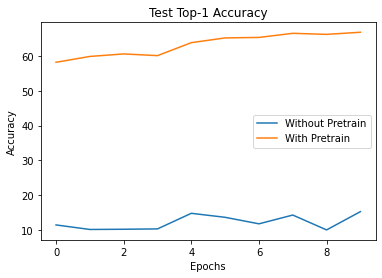

In [38]:
plt.plot(no_pretrain_results['test_acc@1'], label="Without Pretrain")
plt.plot(pretrain_results['test_acc@1'], label="With Pretrain")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Top-1 Accuracy')
plt.legend()
plt.show()